# Import


In [8]:
import os
import glob
import subprocess
import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
import gc
import logging
import warnings

# Installa keras-tuner
try:
    print("Installazione di keras-tuner in corso...")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "keras-tuner", "--upgrade"])
    print("Installazione completata!")
except subprocess.CalledProcessError as e:
    print(f"Errore durante l'installazione: {e}")

# Verifica l'importazione
try:
    import keras_tuner as kt
    print("Keras Tuner è stato caricato correttamente!")
except ImportError:
    print("Errore: Keras Tuner non è disponibile. Verifica l'installazione.")
import keras_tuner as kt

#subprocess.check_call(["pip", "install", "--upgrade", "pip"])

# Aggiorna keras-tuner
#subprocess.check_call(["pip", "install", "--upgrade", "keras-tuner"])

# Aggiorna tensorflow
subprocess.check_call(["pip", "install", "--upgrade", "tensorflow"])
from rich.console import Console
from rich.table import Table
from rich.text import Text
from google.colab import drive
from PIL import Image
from keras.preprocessing.image import save_img
from keras.layers import Rescaling
from keras.models import Sequential
from keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Conv2D, AveragePooling2D, Flatten, Dense, Activation, BatchNormalization, MaxPooling2D
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


warnings.filterwarnings("ignore")

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Questo rimuove i log informativi e warnings di TensorFlow
tf.get_logger().setLevel(logging.ERROR)

os.environ['PYTHONWARNINGS'] = 'ignore'

logging.getLogger('tensorflow').setLevel(logging.ERROR)

Installazione di keras-tuner in corso...
Installazione completata!
Keras Tuner è stato caricato correttamente!


# Dataset retrieve

In [3]:
# Mount Google Drive
drive.mount('/content/drive')

# Folder path on google drive
dataset_path = '/content/drive/My Drive/Colab Notebooks/chest_xray'


# Verifica l'accesso alla directory senza smontare
if os.path.exists(dataset_path):
    print("Percorso trovato")

    # Usa glob per ottenere il contenuto della directory
    folders = glob.glob(f'{dataset_path}/*')
    print("Contenuto della directory:")
    for folder in folders:
        print(folder)
else:
    print("Percorso non trovato, controllare il montaggio.")
print(os.listdir(dataset_path))

Mounted at /content/drive
Percorso trovato
Contenuto della directory:
/content/drive/My Drive/Colab Notebooks/chest_xray/test
/content/drive/My Drive/Colab Notebooks/chest_xray/train
/content/drive/My Drive/Colab Notebooks/chest_xray/autoencoder_images
/content/drive/My Drive/Colab Notebooks/chest_xray/train_ae_normal
/content/drive/My Drive/Colab Notebooks/chest_xray/train_ae_pneumonia
/content/drive/My Drive/Colab Notebooks/chest_xray/config2
/content/drive/My Drive/Colab Notebooks/chest_xray/config1
/content/drive/My Drive/Colab Notebooks/chest_xray/best_model_so_far
['test', 'train', 'autoencoder_images', 'train_ae_normal', 'train_ae_pneumonia', 'config2', 'config1', 'best_model_so_far']




# Dataset manipulation


Questa porzione di codice è responsabile delle trasformazioni applicate ai dati per fare data augmentation. Il codice contiene una funzione per croppare l'immagine in input, che sia RGB o in scala di grigi. La funzione calcola le nuove dimensioni dell'immagine sulla base di un crop_ratio randomico. In seguito, calcola il punto dove effettua il crop (dall'angolo in alto a sinistra). Infine, calcola il padding necessario per riportare l'immagine alle sue dimensioni originali attraverso lo scarto tra queste e le dimensioni dell'immagine croppata. Non viene effettuato padding a livello di canali, e il padding effettuato è a valore 0, cioè si effettua padding con pixel neri.
Infine, il codice esegue data augmentation sulle radiografie contenute in input_folder. Viene impiegato un ImageDataGenerator per applicare trasformazioni come rotazione, traslazione, shear* e la funzione personalizzata di crop e padding definita in precedenza. Per ogni immagine originale, genera due immagini augmentate e le salva nella cartella output_folder.

*Lo shearing è una trasformazione geometrica che inclina un'immagine lungo un asse (orizzontale o verticale), spostando proporzionalmente i punti senza modificarne l'area totale. Questo crea un effetto di distorsione simile a una proiezione obliqua.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from PIL import Image

# Funzione custom per eseguire il crop e il padding
def random_crop_pad(image, crop_pad_ratio=0.10):
    """
    Applica un crop casuale all'immagine e successivamente aggiunge padding
    per riportare l'immagine alle dimensioni originali.

    Args:
        image: numpy array dell'immagine [shape: (altezza, larghezza)]
        crop_pad_ratio: frazione massima dell'immagine da ritagliare (0-0.10)

    Returns:
        L'immagine trasformata con crop e padding.
    """
    h, w = image.shape[0], image.shape[1]
    # Calcola il fattore di crop casuale: una frazione compresa tra 0 e crop_pad_ratio
    crop_fraction = np.random.uniform(0, crop_pad_ratio)
    # Determina le nuove dimensioni dopo il crop
    new_h = int(h * (1 - crop_fraction))
    new_w = int(w * (1 - crop_fraction))
    new_h = max(1, new_h)
    new_w = max(1, new_w)

    # Seleziona casualmente la posizione del crop
    top = np.random.randint(0, h - new_h + 1) if (h - new_h) > 0 else 0
    left = np.random.randint(0, w - new_w + 1) if (w - new_w) > 0 else 0
    cropped = image[top:top+new_h, left:left+new_w, ...]

    # Calcola quanto padding è necessario per riportare l'immagine alle dimensioni originali
    pad_h = h - new_h
    pad_w = w - new_w
    pad_top = np.random.randint(0, pad_h + 1) if pad_h > 0 else 0
    pad_bottom = pad_h - pad_top
    pad_left = np.random.randint(0, pad_w + 1) if pad_w > 0 else 0
    pad_right = pad_w - pad_left

    # Applica il padding: utilizziamo il padding con costante (0) per riempire le aree mancanti.
    if image.ndim == 3:
        padded = np.pad(cropped, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                        mode='constant', constant_values=0)
    else:
        padded = np.pad(cropped, ((pad_top, pad_bottom), (pad_left, pad_right)),
                        mode='constant', constant_values=0)
    return padded

# Parametri e configurazione cartelle
input_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL'
output_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/temp_normal_augmented'
os.makedirs(output_folder, exist_ok=True)

# Definizione del generatore di immagini
datagen = ImageDataGenerator(
    rotation_range=17,          # Rotazione casuale (-17° e +17°)
    width_shift_range=0.10,     # Traslazione orizzontale fino al 10%
    height_shift_range=0.10,     # Traslazione verticale fino al 10%
    shear_range=10,             # Shear fino a 10°

    # Utilizziamo una funzione di preprocessing per eseguire crop e padding
    preprocessing_function=lambda x: random_crop_pad(x, crop_pad_ratio=0.10),
    fill_mode='nearest'
)

# Ottieniamo la lista delle immagini originali
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Numero di immagini originali: {len(image_files)}.")

generated_count = 0

# Loop per la generazione di due immagini augmentate per ogni immagine
for img_file in image_files:
    img_path = os.path.join(input_folder, img_file)
    img = Image.open(img_path)
    img_array = np.array(img)

    # Se l'immagine è in scala di grigi, aggiungiamo una dimensione per il canale
    if img_array.ndim == 2:
        img_array = np.expand_dims(img_array, axis=-1)

    # Aggiungiamo la dimensione del batch (necessaria per il generatore)
    img_array = np.expand_dims(img_array, axis=0)

    # Creiamo l'iteratore per le trasformazioni
    aug_iter = datagen.flow(img_array, batch_size=1)

    # Generiamo due immagini augmentate per questa immagine
    for i in range(2):
        batch = next(aug_iter)
        augmented_img = batch[0].astype('uint8')
        output_path = os.path.join(output_folder, f"augmented_{generated_count}.jpg")
        save_img(output_path, augmented_img)
        generated_count += 1

print(f"Generazione completata. Totale immagini generate: {generated_count}.")


KeyboardInterrupt: 

#Pneumonia Augmentation

Questo codice è analogo a quello contenuto nella sezione Data Manipulation. Per provare la configurazione n.4 è stata eseguita data augmentation anche sulle radiografie etichettate come PNEUMONIA. Diversamente da quanto succede nella sezione precedente, ogni radiografia PNEUMONIA dà origine ad una augmentata. Questa scelta è motivata dallo sbilanciamento iniziale del dataset originale, che conteneva molte più radiografie di polmoni malati piuttosto che polmoni sani.

In [ ]:
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator, save_img
from PIL import Image

# Funzione custom per eseguire il crop e il padding
def random_crop_pad(image, crop_pad_ratio=0.10):

    h, w = image.shape[0], image.shape[1]
    # Calcola il fattore di crop casuale: una frazione compresa tra 0 e crop_pad_ratio
    crop_fraction = np.random.uniform(0, crop_pad_ratio)
    # Determina le nuove dimensioni dopo il crop
    new_h = int(h * (1 - crop_fraction))
    new_w = int(w * (1 - crop_fraction))
    new_h = max(1, new_h)
    new_w = max(1, new_w)

    # Seleziona casualmente la posizione del crop
    top = np.random.randint(0, h - new_h + 1) if (h - new_h) > 0 else 0
    left = np.random.randint(0, w - new_w + 1) if (w - new_w) > 0 else 0
    cropped = image[top:top+new_h, left:left+new_w, ...]

    # Calcola quanto padding è necessario per riportare l'immagine alle dimensioni originali
    pad_h = h - new_h
    pad_w = w - new_w
    pad_top = np.random.randint(0, pad_h + 1) if pad_h > 0 else 0
    pad_bottom = pad_h - pad_top
    pad_left = np.random.randint(0, pad_w + 1) if pad_w > 0 else 0
    pad_right = pad_w - pad_left

    # Applica il padding con costante (0) per riempire le aree mancanti.
    if image.ndim == 3:
        padded = np.pad(cropped, ((pad_top, pad_bottom), (pad_left, pad_right), (0, 0)),
                        mode='constant', constant_values=0)
    else:
        padded = np.pad(cropped, ((pad_top, pad_bottom), (pad_left, pad_right)),
                        mode='constant', constant_values=0)
    return padded

#  Parametri e configurazione cartelle
input_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA'
output_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/temp_pneumonia_augmented'
os.makedirs(output_folder, exist_ok=True)

# Definizione del generatore di immagini
datagen = ImageDataGenerator(
    rotation_range=17,          # Rotazione casuale tra -17° e +17°
    width_shift_range=0.10,     # Traslazione orizzontale fino al 10%
    height_shift_range=0.10,    # Traslazione verticale fino al 10%
    shear_range=10,             # Shear fino a 10°

    # Applichiamo il crop e padding tramite funzione di preprocessing
    preprocessing_function=lambda x: random_crop_pad(x, crop_pad_ratio=0.10),
    fill_mode='nearest'
)

# Otteniamo la lista delle immagini nella cartella PNEUMONIA
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
print(f"Numero di immagini originali: {len(image_files)}.")

generated_count = 0

# Loop per generare una immagine augmentata per ogni immagine originale
for img_file in image_files:
    img_path = os.path.join(input_folder, img_file)
    img = Image.open(img_path)
    img_array = np.array(img)

    # Se l'immagine è in scala di grigi, aggiungiamo una dimensione per il canale
    if img_array.ndim == 2:
        img_array = np.expand_dims(img_array, axis=-1)

    # Aggiungiamo la dimensione del batch (necessaria per il generatore)
    img_array = np.expand_dims(img_array, axis=0)

    # Creiamo l'iteratore per le trasformazioni
    aug_iter = datagen.flow(img_array, batch_size=1)

    # Generiamo una immagine augmentata per questa immagine
    batch = next(aug_iter)
    augmented_img = batch[0].astype('uint8')
    output_path = os.path.join(output_folder, f"augmented_{generated_count}.jpg")
    save_img(output_path, augmented_img)
    generated_count += 1

print(f"Generazione completata. Totale immagini generate: {generated_count}.")


Numero di immagini originali: 3883.
Generazione completata. Totale immagini generate: 3883.


# Image cropping


Questa sezione di codice non viene utilizzata nell'implementazione finale del modello. Durante le fasi iniziali del progetto, a causa delle grandi dimensioni delle radiografie (circa 650 x 600 pixel), è stata sperimentata una tecnica di cropping per rimuovere elementi non rilevanti ai fini della diagnosi di polmonite. L'obiettivo era eliminare porzioni come collo e spalle, concentrandosi meglio sulla cassa toracica, parte fondamentale per la diagnosi della polmonite. Il codice esegue due operazioni principali:
Cropping delle immagini, rimuovendo il 5% dei lati sinistro e destro e il 7% della parte superiore per eliminare dettagli irrilevanti per poi salvarle in una cartella di output. Infine, effettua la copia dei file e delle sottocartelle da una cartella sorgente a una di destinazione, mantenendo la struttura dei dati per un'adeguata organizzazione del dataset.

In [ ]:
import os
import shutil

# Cartelle di input e output
input_folders = [
    '/content/drive/My Drive/Colab Notebooks/chest_xray/train/NORMAL',
    '/content/drive/My Drive/Colab Notebooks/chest_xray/train/temp_normal_augmented'
]
output_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/config1/train/NORMAL'

# Crea la cartella di output se non esiste
os.makedirs(output_folder, exist_ok=True)

# Funzione per eseguire il cropping delle immagini
def crop_image(img):
    # Ottieni le dimensioni dell'immagine (larghezza, altezza)
    width, height = img.size

    # Calcola la quantità di pixel da tagliare
    left_crop = int((5 / 100) * width)    # % della larghezza da sinistra
    top_crop = int((7 / 100) * height)    # % dell'altezza da sopra
    right_crop = int((5 / 100) * width)   # % della larghezza da destra

    # Definisci la regione da mantenere: (left, top, right, bottom)
    cropped_img = img.crop((left_crop, top_crop, width - right_crop, height))
    return cropped_img

# Ottieni la lista delle immagini da entrambe le cartelle di input
image_files = []
for folder in input_folders:
    image_files += [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

count = 0
# Per ogni immagine, applica il cropping e salva nella cartella di output
for img_file in image_files:
    # Determina la cartella di origine
    for folder in input_folders:
        img_path = os.path.join(folder, img_file)
        if os.path.exists(img_path):
            break

    # Carica l'immagine
    img = Image.open(img_path)

    # Esegui il cropping
    cropped_img = crop_image(img)

    # Salva l'immagine croppata nella cartella di output
    output_path = os.path.join(output_folder, f"cropped_{img_file}")

    # Se l'immagine è in scala di grigi, convertila in RGB prima di salvarla
    if cropped_img.mode == 'L':  # Se l'immagine è in scala di grigi ('L')
        cropped_img = cropped_img.convert('RGB')  # Convertila in RGB per evitare errori nel salvataggio

    cropped_img.save(output_path)

print(f"Generazione completata. Le immagini croppate sono salvate in '{output_folder}'.")

def copy_folder_content(src_folder, dest_folder):
    # Controlla che la cartella sorgente esista
    if not os.path.exists(src_folder):
        print(f"Errore: La cartella sorgente {src_folder} non esiste.")
        return

    # Crea la cartella di destinazione se non esiste
    if not os.path.exists(dest_folder):
        os.makedirs(dest_folder)
        print(f"La cartella di destinazione {dest_folder} è stata creata.")

    # Copia i file e le sottocartelle
    for item in os.listdir(src_folder):
        src_path = os.path.join(src_folder, item)
        dest_path = os.path.join(dest_folder, item)

        if os.path.isdir(src_path):
            # Copia la sottocartella
            shutil.copytree(src_path, dest_path, dirs_exist_ok=True)
        else:
            # Copia il file
            shutil.copy2(src_path, dest_path)

    print(f"Contenuto copiato da {src_folder} a {dest_folder}.")

# Percorsi delle cartelle
src_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/PNEUMONIA'
dest_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/config1/train/PNEUMONIA'
copy_folder_content(src_folder, dest_folder)



KeyboardInterrupt: 

#Tabelle Modello

Questo frammento di codice utilizza la libreria Rich per la visualizzazione di messaggi e tabelle nei risultati di valutazione del modello.

In [ ]:
console = Console()

# Funzione per stampare un messaggio con un determinato stile
def print_message(message, style):
    text = Text(message, style=style)
    console.print(text)

# Funzione per stampare una tabella con Rich
def print_table(title, columns, rows):
    table = Table(title=title)
    for col in columns:
        table.add_column(col['header'], justify=col.get('justify', 'center'), style=col.get('style', 'bright_white'))
    for row in rows:
        table.add_row(*row)
    console.print(table)

# Funzione per stampare un messaggio di successo
def printSuccess(message):
    print_message(message, "bold bright_green")

# Funzione per stampare un messaggio di errore
def printError(message):
    print_message(message, "bold bright_red")

# Crea e stampa una tabella formattata
def create_rich_table(title, columns, rows):
    table = Table(title=title)

    # Aggiungi colonne alla tabella
    for col in columns:
        table.add_column(col['header'], justify=col.get('justify', 'center'), style=col.get('style', 'bright_white'))

    # Aggiungi righe alla tabella
    for row in rows:
        table.add_row(*row)

    # Stampa la tabella
    console.print(table)


# Funzione per stampare la tabella di valutazione del modello
def print_evaluation_table(model_name, test_class_report, test_accuracy):
    rows = [
        ["Accuracy", f"{test_accuracy:.4f}"],
        ["Precision (wgtd_avg)", f"{test_class_report['weighted avg']['precision']:.4f}"],
        ["Recall (wgtd_avg)", f"{test_class_report['weighted avg']['recall']:.4f}"],
        ["F1-Score (wgtd_avg)", f"{test_class_report['weighted avg']['f1-score']:.4f}"]
    ]
    columns = [{"header": "Metric", "style": "bright_cyan"}, {"header": "Result", "style": "bright_green", "justify": "center"}]
    print_table("Model Evaluation Results for " + model_name, columns, rows)

# Funzione per stampare una tabella con i migliori iperparametri
def print_best_params_table(model_name, best_params):
    rows = [[param, str(value)] for param, value in best_params.items()]
    columns = [{"header": "Hyperparameter", "style": "bright_cyan"}, {"header": "Value", "style": "bright_magenta", "justify": "center"}]
    print_table("Best Hyperparameters for " + model_name, columns, rows)

# Funzione per stampare una tabella con i migliori iperparametri CNN
def print_best_hyperparameters(model_name, best_hps):
    rows = [[param, str(best_hps.get(param))] for param in best_hps.values.keys()]
    columns = [{"header": "Hyperparameter", "style": "bright_cyan"}, {"header": "Value", "style": "bright_magenta", "justify": "center"}]
    print_table("Best Hyperparameters for " + model_name, columns, rows)

#Valutazione e Visualizzazione

Questo script fornisce un insieme di funzioni per valutare, salvare e visualizzare i risultati dei modelli che abbiamo testato. Permette di salvare le metriche chiave dei modelli, come accuratezza, precisione, recall e F1-score, in un dizionario globale per il confronto tra diverse architetture. La valutazione viene effettuata calcolando le metriche di classificazione sui dati di test e visualizzando l'andamento della loss e dell'accuratezza nel numero di epoche tramite grafici (mostrati nelle slide di presentazione). Inoltre, include funzionalità per analizzare le attivazioni intermedie dei livelli convoluzionali, consentendo di comprendere le trasformazioni apprese dal modello. Un'ulteriore funzione (inutilizzata in realtà) consente di confrontare più modelli CNN addestrati, generando grafici comparativi delle loro prestazioni in termini delle metriche precedentemente elencate.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import tensorflow as tf
from tensorflow import keras
from sklearn.metrics import classification_report, accuracy_score

# Dizionario globale per salvare i risultati dei modelli
cnn_model_results = {}

def save_cnn_results(model_name, test_class_report, test_accuracy):
    """Salva i risultati del modello CNN nel dizionario globale."""
    cnn_model_results[model_name] = {
        'Test Accuracy': test_accuracy,
        'Test Precision': test_class_report['weighted avg']['precision'],
        'Test Recall': test_class_report['weighted avg']['recall'],
        'Test F1-Score': test_class_report['weighted avg']['f1-score']
    }

def evaluate_cnn(model_name, model, images_testing, labels_testing, history, figsize=(8, 5)):
    """Esegue la valutazione del modello CNN e salva i risultati."""
    y_test_pred_prob = model.predict(images_testing)
    y_test_pred = np.argmax(y_test_pred_prob, axis=1)
    labels_testing = np.argmax(labels_testing, axis=1) if labels_testing.ndim > 1 else labels_testing

    test_class_report = classification_report(labels_testing, y_test_pred, output_dict=True)
    test_accuracy = accuracy_score(labels_testing, y_test_pred)

    #print_evaluation_table(model_name, test_class_report, test_accuracy)

    # Visualizzazione dell'andamento della loss e dell'accuratezza
    pd.DataFrame(history.history).plot(figsize=figsize)
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.show()

def plot_feature_maps(output, title="", max_maps=20):
    """Mostra le feature maps di un livello convoluzionale."""
    if len(output.shape) == 4:
        n = min(max_maps, output.shape[-1])
        cols = 5 if n >= 5 else 3
        rows = int(math.ceil(n / cols))
        fig, axs = plt.subplots(rows, cols, figsize=(8, 2.5 * rows))
        fig.suptitle(title)
        for i, ax in enumerate(axs.flat):
            if i < n:
                ax.imshow(output[0, :, :, i], interpolation="nearest", cmap="viridis")
            ax.axis("off")

def plot_cnn_transformations(model, sample_image):
    """Visualizza le trasformazioni subite da un'immagine nei vari strati convoluzionali della CNN."""
    for layer in model.layers:
        if 'conv' in layer.name:
            truncated_model = keras.Model(inputs=model.input, outputs=layer.output)
            output = truncated_model.predict(sample_image[np.newaxis, ...])
            plot_feature_maps(output, title=f"Activations of Layer: {layer.name}")

def plot_cnn_comparison(y_lim=(0, 1)):
    """Confronta le metriche dei modelli CNN salvati."""
    df_results = pd.DataFrame(cnn_model_results).transpose()
    df_results.reset_index(inplace=True)
    df_results.rename(columns={'index': 'Model'}, inplace=True)

    sns.set(style="whitegrid")
    palette = sns.color_palette("bright", len(df_results))

    plt.figure(figsize=(20, 12))
    metrics = ['Test Accuracy', 'Test F1-Score', 'Test Precision', 'Test Recall']
    titles = ['Accuracy Comparison', 'F1-Score Comparison', 'Precision Comparison', 'Recall Comparison']

    for i, metric in enumerate(metrics):
        plt.subplot(2, 2, i+1)
        sns.barplot(x='Model', y=metric, data=df_results, palette=palette)
        plt.title(titles[i])
        plt.ylabel(metric)
        plt.ylim(y_lim)

    plt.tight_layout()
    plt.show()


## Metriche

La funzione evaluate_model_performance calcola le principali metriche di valutazione, tra cui accuratezza, precisione, recall, F1-score e AUC, confrontando le etichette predette dal modello con quelle reali del dataset di test. La soglia di classificazione può essere regolata per convertire le probabilità predette in etichette binarie. I risultati vengono stampati in console e restituiti in un dizionario.

La funzione plot_metrics genera un diagramma a barre per rappresentare graficamente le metriche calcolate, utilizzando una colormap per rendere più leggibile il confronto tra le varie prestazioni. Il grafico include etichette, una griglia di riferimento e annotazioni sui valori, per una migliroe comprensione dei risultati.

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model_performance(model, test_images, test_labels, threshold=0.5):
    """
    Valuta le performance del modello calcolando le seguenti metriche:
      - Accuracy
      - Precision
      - Recall
      - F1 Score
      - AUC

    Parametri:
      model       : modello addestrato
      test_images : numpy array contenente le immagini del test sey
      test_labels : numpy array contenente le etichette del test set
      threshold   : soglia per convertire le probabilità in etichette binarie (default=0.5)

    Ritorna:
      metrics_dict : dizionario contenente le metriche calcolate
    """

    # Ottieni le probabilità predette dal modello sul set di test
    y_prob = model.predict(test_images)

    # Conversione delle probabilità in etichette binarie utilizzando la soglia
    y_pred = (y_prob > threshold).astype(int).flatten()
    y_true = test_labels.flatten()

    # Calcola le metriche
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)

    # Stampa i risultati in console
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"AUC:       {auc:.4f}")

    # Ritorna un dizionario con le metriche calcolate
    metrics_dict = {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1,
        "auc": auc
    }
    return metrics_dict

def plot_metrics(metrics, title="Metriche di Performance"):
    """
    Genera un diagramma a barre in cui ogni barra rappresenta una metrica
    con il relativo valore (compreso tra 0 e 1).
    """
    # Estrazione delle chiavi e dei valori dal dizionario
    metriche = list(metrics.keys())
    valori = list(metrics.values())

    # Imposta uno stile più gradevole
    plt.style.use('ggplot')

    # Imposta un font
    plt.rcParams['font.family'] = 'DejaVu Sans'
    plt.rcParams['font.size'] = 12

    # Creazione della figura e degli assi
    fig, ax = plt.subplots(figsize=(12, 8))

    # Genera una colormap per assegnare un colore diverso a ogni barra
    colors = [cm.viridis(i / len(metriche)) for i in range(len(metriche))]

    # Creazione del diagramma a barre con bordi per renderle più definite
    bars = ax.bar(metriche, valori, color=colors, edgecolor='black', linewidth=1.2)

    # Impostazione della scala y (aggiungendo un po' di margine in alto)
    ax.set_ylim(0, 1.1)

    # Aggiunta di etichette e titolo con padding per evitare sovrapposizioni
    ax.set_xlabel("Metriche", fontsize=14, labelpad=10)
    ax.set_ylabel("Valore", fontsize=14, labelpad=10)
    ax.set_title(title, fontsize=16, pad=15)

    # Ruota le etichette dell'asse x per evitare che si sovrappongano
    plt.xticks(rotation=45, ha='right')

    # Aggiunta della griglia (solo orizzontale)
    ax.grid(True, axis='y', linestyle='--', alpha=0.7)

    # Rimuovi le spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Annotazione di ogni barra con il relativo valore
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, yval + 0.03, f"{yval:.2f}",
                ha='center', va='bottom', fontsize=12, fontweight='bold')

    # Regola i margini in modo automatico
    plt.tight_layout()
    plt.show()





# Preprocessing dataset

In questa sezione di codice ci occupiamo della fase di preprocessing. Prima di tutto impostiamo un seed fisso per garantire la riproducibilità degli esperimenti di training. Il preprocessing può essere eseguito in quattro diverse configurazioni, dove il Training Set è composto da:

1.   Radiografie Normal originali + radiografie normal_augmented dove ogni normal originale viene augmentata due volte (PNEUMONIA non viene augmentato)

2.   Radiografie Normal originali + radiografie generate da un VAE allenato sul nostro dataset, in numero sono circa 2000 (PNEUMONIA non viene augmentato)

3.   Radiografie Normal e Pneumonia originali, non viene eseguita data augmentation

4.   Radiografie Normal originali + radiografie normal_augmented dove ogni normal originale viene augmentata due volte, inoltre vengono utilizzate anche le pneumonia augmented (3900 in numero)

La cartella di test non è stata manipolata in nessun modo.

In seguito, ridimensioniamo le radiografie dalle dimensioni originali a 64x64, in modo da alleggerire il training, sia da un punto di vista temporale che da uno di memoria occupata.

Utilizziamo dei batch per ridurre il consumo di memoria e migliorare l'efficienza dell'addestramento.

La scelta della dimensione dei batch utilizzati per il training è ricaduta su 32. Abbiamo anche provato ad utilizzare batch da 64, ma abbiamo preferito usare 32 per le seguenti ragioni: batch più piccoli introducono più rumore nella stima del gradiente, migliorando la capacità di generalizzazione del modello. Inoltre, il modello aggiorna i pesi più frequentemente rispetto a batch di 64, introducendo una maggiore variabilità che può ridurre l' overfitting. Il modello con batch da 32 aggiorna i pesi più frequentemente rispetto ad uno da 64, favorendo la convergenza. Considerando che il nostro dataset non è enorme (dell'ordine di 7-8k radiografie), un batch di 64 potrebbe ridurre troppo la variabilità nelle iterazioni di training.

Per quanto riguarda il validation set, abbiamo diviso il nostro training set in 80% effettivo per il training e 20% per il validation set. Abbiamo fatto in modo che il validation sia composto da 50% radiografie NORMAL e 50% PNEUMONIA. Inoltre il validation set include esclusivamente radiografie originali, quindi non augmentate. Queste scelte sono dovute al fatto che scegliendo un rapporto Normal/Pneumonia uguale a quello nel test set, si introdurrebbe un bias nella valutazione del modello, poiché verrebbe valutato su una distribuzione sbilanciata simile a quella del test set, rendendo difficile capire se il modello sta realmente apprendendo o se sista semplicemente adattando alla distribuzione dei dati. La scelta dell'esclusione di immagini augmentate dal validation set è motivata dal fatto che queste potrebbero non essere perfettamente rappresentative della realtà (come quelle nel test set) e potrebbero portare ad una ricerca dei pesi non ottimale, oltre che ad una ulteriore introduzione di bias nella valutazione delle performance.

Infine, oltre all'utilizzo di varie funzioni di stampa per assicurarsi un corretto funzionamento del codice, vengono creati generatori di dati con ImageDataGenerator di Keras per ottimizzare il caricamento delle immagini in batch. Il train_generator e il val_generator caricano le immagini dalla memoria, mentre un test_generator separato esegue solo il rescaling, mantenendo le immagini in scala di grigi e in modalità binaria. L'operazioone inoltre non permuta l'ordine dei dati.




In [ ]:
import os
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Imposta un seed per garantire la riproducibilità
random.seed(42)
np.random.seed(42)
tf.random.set_seed(42)

# Percorsi delle cartelle
train_folder_1 = '/content/drive/My Drive/Colab Notebooks/chest_xray/train'   # Dati augmentati attraverso trasformazioni
train_folder_2 = '/content/drive/My Drive/Colab Notebooks/chest_xray/config2'  # Dati augmentati con VAE
test_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/test'

# Cartella per le immagini augmentate di PNEUMONIA (Configurazione 4)
pneumonia_augmented_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train/temp_pneumonia_augmented'

# Modalità di preprocessing:
# 1: usa train_folder_1 (augmented images contrassegnate da "augmented")
# 2: usa train_folder_2 (augmented images contrassegnate da "generated")
# 3: preprocessing SENZA data augmentation (scarta le immagini augmentate)
# 4: usa train_folder_1 e, inoltre, le immagini augmentate di PNEUMONIA dalla cartella pneumonia_augmented_folder
TRAIN_FOLDER_CHOICE = 1  # Modifica a 1, 2, 3 o 4 secondo necessità

# Per identificare le immagini augmentate in train_folder_1
augmented_photos_name = ''
if TRAIN_FOLDER_CHOICE == 1:
    train_folder = train_folder_1
    augmented_photos_name = 'augmented'
elif TRAIN_FOLDER_CHOICE == 2:
    train_folder = train_folder_2
    augmented_photos_name = 'generated'
elif TRAIN_FOLDER_CHOICE == 3:
    train_folder = train_folder_1
    augmented_photos_name = 'augmented'
elif TRAIN_FOLDER_CHOICE == 4:
    train_folder = train_folder_1
    augmented_photos_name = 'augmented'

# Stampa esplicita della configurazione scelta
print("================================================================")
print("Configurazione scelta: TRAIN_FOLDER_CHOICE =", TRAIN_FOLDER_CHOICE)
if TRAIN_FOLDER_CHOICE == 1:
    print(" -> Utilizzo train_folder_1: dati da trasformazioni, immagini augmentate contrassegnate da 'augmented'.")
elif TRAIN_FOLDER_CHOICE == 2:
    print(" -> Utilizzo train_folder_2: dati da VAE, immagini augmentate contrassegnate da 'generated'.")
elif TRAIN_FOLDER_CHOICE == 3:
    print(" -> Utilizzo train_folder_1, escludendo immagini augmentate ('augmented') per preprocessing SENZA data augmentation.")
elif TRAIN_FOLDER_CHOICE == 4:
    print(" -> Utilizzo train_folder_1 e le immagini augmentate di PNEUMONIA dalla cartella 'temp_pneumonia_augmented'.")
print("================================================================\n")

# Flag per decidere se includere o meno le immagini augmentate nel Validation set
# (In modalità 3 queste immagini sono già escluse)
INCLUDE_AUGMENTED_IN_VALIDATION = False  # Imposta a True per includere immagini augmentate nel validation

# Parametri
batch_size = 32
image_size = (64, 64)

##############################################################################
# 1. Separazione delle immagini originali e augmentate dal training set
##############################################################################

# Liste per memorizzare i file e le relative etichette
original_files = []
original_labels = []
augmented_files = []
augmented_labels = []

# Scansione delle sottocartelle in train_folder
for subdir in os.listdir(train_folder):
    subdir_path = os.path.join(train_folder, subdir)
    if os.path.isdir(subdir_path):
        subdir_lower = subdir.lower()
        # Caso NORMAL (per cui vogliamo sia originali che augmentate)
        if 'normal' in subdir_lower:
            label = 0
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(subdir_path, filename)
                    # Se il file contiene "augmented" lo consideriamo come augmentato,
                    # altrimenti come originale.
                    if augmented_photos_name in filename.lower():
                        augmented_files.append(file_path)
                        augmented_labels.append(label)
                    else:
                        original_files.append(file_path)
                        original_labels.append(label)
        # Caso PNEUMONIA
        else
            label = 1
            for filename in os.listdir(subdir_path):
                if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                    file_path = os.path.join(subdir_path, filename)
                    # Per TRAIN_FOLDER_CHOICE 1, 3 e 4 vogliamo escludere le immagini augmentate per pneumonia
                    if TRAIN_FOLDER_CHOICE in [1, 3, 4]:
                        if augmented_photos_name in filename.lower():
                            continue  # scarta le immagini pneumonia augmentate
                        else:
                            original_files.append(file_path)
                            original_labels.append(label)
                    else:
                        # Per TRAIN_FOLDER_CHOICE == 2, si utilizzano anche le immagini augmentate
                        if augmented_photos_name in filename.lower():
                            augmented_files.append(file_path)
                            augmented_labels.append(label)
                        else:
                            original_files.append(file_path)
                            original_labels.append(label)


# Configurazione 4: aggiungi le immagini augmentate di PNEUMONIA dalla cartella dedicata
if TRAIN_FOLDER_CHOICE == 4:
    if not os.path.isdir(pneumonia_augmented_folder):
        print("La cartella pneumonia_augmented_folder non esiste. Creazione cartella...:", pneumonia_augmented_folder)
        os.makedirs(pneumonia_augmented_folder, exist_ok=True)
    for filename in os.listdir(pneumonia_augmented_folder):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(pneumonia_augmented_folder, filename)
            augmented_files.append(file_path)
            augmented_labels.append(1)

##############################################################################
# 2. Suddivisione in Training e Validation
##############################################################################

val_frac = 0.2  # Frazione complessiva per il validation set

if not INCLUDE_AUGMENTED_IN_VALIDATION:
    # UTILIZZA SOLO le immagini originali per il validation set

    # Separa le immagini originali per classe
    normal_orig = [f for f, lbl in zip(original_files, original_labels) if lbl == 0]
    pneumonia_orig = [f for f, lbl in zip(original_files, original_labels) if lbl == 1]

    # Mescola i file per evitare bias
    random.shuffle(normal_orig)
    random.shuffle(pneumonia_orig)

    total_orig = len(original_files)
    val_size = int(total_orig * val_frac)

    # Distribuzione target (50% NORMAL e 50% PNEUMONIA nel validation)
    val_normal_count = int(val_size * 0.5)
    val_pneumonia_count = val_size - val_normal_count

    val_normal_count = min(val_normal_count, len(normal_orig))
    val_pneumonia_count = min(val_pneumonia_count, len(pneumonia_orig))

    val_files_normal = normal_orig[:val_normal_count]
    val_files_pneumonia = pneumonia_orig[:val_pneumonia_count]
    val_files = val_files_normal + val_files_pneumonia
    val_labels = [0] * len(val_files_normal) + [1] * len(val_files_pneumonia)

    # Le immagini originali rimanenti costituiranno la parte "originale" del training set
    train_orig_files = normal_orig[val_normal_count:] + pneumonia_orig[val_pneumonia_count:]
    train_orig_labels = [0] * (len(normal_orig) - val_normal_count) + [1] * (len(pneumonia_orig) - val_pneumonia_count)

    # In modalità 1, 2 e 4 si aggiungono anche le immagini augmentate; in modalità 3 esse sono già escluse
    train_files = train_orig_files + (augmented_files if TRAIN_FOLDER_CHOICE != 3 else [])
    train_labels = train_orig_labels + (augmented_labels if TRAIN_FOLDER_CHOICE != 3 else [])
else:
    # Se INCLUDE_AUGMENTED_IN_VALIDATION è True
    all_files = original_files + augmented_files
    all_labels = original_labels + augmented_labels

    normal_all = [f for f, lbl in zip(all_files, all_labels) if lbl == 0]
    pneumonia_all = [f for f, lbl in zip(all_files, all_labels) if lbl == 1]

    random.shuffle(normal_all)
    random.shuffle(pneumonia_all)

    total_all = len(all_files)
    val_size = int(total_all * val_frac)

    val_normal_count = int(val_size * 0.5)
    val_pneumonia_count = val_size - val_normal_count

    val_normal_count = min(val_normal_count, len(normal_all))
    val_pneumonia_count = min(val_pneumonia_count, len(pneumonia_all))

    val_files_normal = normal_all[:val_normal_count]
    val_files_pneumonia = pneumonia_all[:val_pneumonia_count]
    val_files = val_files_normal + val_files_pneumonia
    val_labels = [0] * len(val_files_normal) + [1] * len(val_files_pneumonia)

    train_files_normal = normal_all[val_normal_count:]
    train_files_pneumonia = pneumonia_all[val_pneumonia_count:]
    train_files = train_files_normal + train_files_pneumonia
    train_labels = [0] * len(train_files_normal) + [1] * len(train_files_pneumonia)

# Mescola il training set
train_combined = list(zip(train_files, train_labels))
random.shuffle(train_combined)
train_files, train_labels = zip(*train_combined)
train_files, train_labels = list(train_files), list(train_labels)

##############################################################################
# Stampa di controllo: dettaglio del Training e Validation Set
##############################################################################
print("\nDettagli Training Set:")
if not INCLUDE_AUGMENTED_IN_VALIDATION:
    if TRAIN_FOLDER_CHOICE != 3:
        print(" - Immagini originali (non usate in validation):", len(train_orig_files))
        print(" - Immagini augmentate (tutte nel training):", len(augmented_files))
    else:
        print(" - Modalità senza data augmentation: solo immagini originali sono considerate")
else:
    num_augmented_in_train = sum(1 for f in train_files if augmented_photos_name in f.lower())
    num_original_in_train = len(train_files) - num_augmented_in_train
    print(" - Immagini originali nel training:", num_original_in_train)
    print(" - Immagini augmentate nel training:", num_augmented_in_train)
print(" - Totale immagini nel Training Set:", len(train_files))
print(" - Immagini NORMAL nel Training Set:", train_labels.count(0))

##############################################################################
# 4. Funzione per caricare le immagini in memoria
##############################################################################
def load_images_and_labels(file_paths, labels, target_size=(64, 64)):
    images = []
    for f in file_paths:
        img = tf.keras.preprocessing.image.load_img(
            f,
            target_size=target_size,
            color_mode='grayscale'
        )
        img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0
        images.append(img_array)
    return np.array(images), np.array(labels)

##############################################################################
# 5. Caricamento in memoria dei set di Training e Validation
##############################################################################
train_images, train_labels_array = load_images_and_labels(train_files, train_labels, image_size)
val_images, val_labels_array = load_images_and_labels(val_files, val_labels, image_size)

train_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_generator = train_datagen.flow(train_images, train_labels_array, batch_size=batch_size)
val_generator = val_datagen.flow(val_images, val_labels_array, batch_size=batch_size)

##############################################################################
# 6. Generatore per il Test Set
##############################################################################
test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=image_size,
    color_mode='grayscale',
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

##############################################################################
# 7. Controllo per verificare la presenza di immagini augmentate nel Validation set
##############################################################################
print("\nValidation set:")
if not INCLUDE_AUGMENTED_IN_VALIDATION:
    augmented_in_val = [f for f in val_files if augmented_photos_name in f.lower()]
    if augmented_in_val:
        print("Attenzione! Il validation set contiene immagini augmentate:")
        for f in augmented_in_val[:10]:
            print(" -", f)
    else:
        print("OK, nessuna immagine 'augmented' nel validation set.")
else:
    print("Il validation set INCLUDE immagini augmentate, in base alla preferenza impostata.")

##############################################################################
# 8. Analisi finale della distribuzione delle classi
##############################################################################
def analyze_class_distribution(labels, set_name):
    unique, counts = np.unique(labels, return_counts=True)
    if len(unique) < 2:
        print(f"\n{set_name} - WARN: c'è solo la classe {unique[0]} presente.")
        return
    count_dict = dict(zip(unique, counts))
    total = sum(count_dict.values())
    print(f"\nDistribuzione delle classi in {set_name}:")
    print(f"   NORMAL: {count_dict.get(0, 0)} ({count_dict.get(0, 0)/total*100:.2f}%)")
    print(f"   PNEUMONIA: {count_dict.get(1, 0)} ({count_dict.get(1, 0)/total*100:.2f}%)")

def analyze_test_set(generator):
    labels = generator.classes
    unique, counts = np.unique(labels, return_counts=True)
    print("\nDistribuzione delle classi nel Test Set:")
    for u, c in zip(unique, counts):
        print(f"   Classe {u}: {c} ({(c/sum(counts))*100:.2f}%)")

print("\nNumero di immagini nel Training set:", len(train_files))
analyze_class_distribution(train_labels, "Training Set")

print("\nNumero di immagini nel Validation set:", len(val_files))
analyze_class_distribution(val_labels, "Validation Set")

print("\nNumero di immagini nel Test set:", test_generator.samples)
analyze_test_set(test_generator)


Configurazione scelta: TRAIN_FOLDER_CHOICE = 1
 -> Utilizzo train_folder_1: dati da trasformazioni, immagini augmentate contrassegnate da 'augmented'.


Dettagli Training Set:
 - Immagini originali (non usate in validation): 4186
 - Immagini augmentate (tutte nel training): 2698
 - Totale immagini nel Training Set: 6884
 - Immagini NORMAL nel Training Set: 3524
Found 624 images belonging to 2 classes.

Validation set:
OK, nessuna immagine 'augmented' nel validation set.

Numero di immagini nel Training set: 6884

Distribuzione delle classi in Training Set:
   NORMAL: 3524 (51.19%)
   PNEUMONIA: 3360 (48.81%)

Numero di immagini nel Validation set: 1046

Distribuzione delle classi in Validation Set:
   NORMAL: 523 (50.00%)
   PNEUMONIA: 523 (50.00%)

Numero di immagini nel Test set: 624

Distribuzione delle classi nel Test Set:
   Classe 0: 234 (37.50%)
   Classe 1: 390 (62.50%)


# Build model


Questa sezione di codice si occupa della definizione e implementazione del modello proposto. A causa di saturazione delle risorse abbiamo introdotto innanzitutto una pulizia parziale dell'ambiente.
Vengono poi impostati dei seed fissi per i generatori casuali per garantire la riproducibilità degli esperimenti.

Il codice prosegue con la definizione degli iperparametri: il valore della regolarizzazione L2 utilizzata in ciascun layer convoluzionale in modo indipendente, a causa della diversità nel numero di filtri in ciascun layer. Allo stesso modo vengono introdotti iperparametri per il valore del dropout scelto e del numero di filtri stesso.

Il modello è strutturato nel modo seguente: vi sono 3 livelli convoluzionali, un layer di GlobalAveragePooling, che sostituisce il Flatten dei feature maps in uscita dal terzo layer convoluzionale. In seguito c'è un Dense Layer con un numero variabile di unità, selezionato dal tuner. Come funzione di attivazione è stata scelta la sigmoide, poichè il nostro task è una classificazione binaria.

Ciascun layer convoluzionale è caratterizzato da:

Kernel di dimensioni (3x3), con stride 1 (implicito poichè non specificato diversamente)

Relu come funzione di attivazione: funzioni come tanh o sigmoid comprimono i valori predetti tra [-1, 1] o [0,1], causando problemi di vanishing gradient durante la fase di backpropagation. Essendo la ReLU definita come f(x) = max(0,x), i gradienti rimangono costanti durante la backpropagation. Inoltre, rispetto alle due funzioni di attivazione citate sopra, è molto semplice e rapida da calcolare, non contenendo esponenziali. Inoltre, poichè per valori negativi restituisce 0, molti neuroni non vengono attivati introducendo sparsità che migliora l'efficienza del modello diminuendo l'overfitting.

Zero padding, poichè la convoluzione standard riduce la dimensione dell'output,
con padding='same', vengono aggiunti zeri attorno ai bordi in modo che l'output abbia la stessa dimensione dell'input. In questo modo non abbiamo una riduzione drastica della dimensionalità dell'input. Con zero padding, i pixel aggiunti sono tutti a valore 0. La scelta di aggiungere padding deriva dal fatto che le immagini che vengono fornite al modello sono dimensionalmente ridotte.

Regolarizzazione L2 nei layer convoluzionali per ridurre l'overfitting, impedendo ai pesi di crescere eccessivamente grazie a una penalità proporzionale alla loro somma dei quadrati. Questo migliora la generalizzazione del modello, rendendolo più efficace su dati mai visti e riducendo il gap tra accuracy di training e validation.

Dopo ogni layer convoluzionale, viene aggiunto:

BatchNormalization per normalizzare le attivazioni durante il training al fine di stabilizzarlo (ed avere una migliore convergenza e perciò meno overfitting).

Un operatore di MaxPooling2D per ridurre la dimensionalità spaziale dei feature maps ed estrarre le caratteristiche più importanti.

Successivamente, un layer denso con attivazione ReLU viene utilizzato per apprendere combinazioni più complesse delle feature estratte, con una regolarizzazione L2 applicata ai pesi per evitare che il modello si adatti eccessivamente ai dati di training. Viene inoltre introdotto Dropout, che spegne casualmente una frazione dei neuroni durante l’addestramento, contribuendo a rendere la rete più resistente alle variazioni nei dati.

Infine, un layer di output con attivazione sigmoide permette di ottenere una probabilità per la classificazione binaria, restituendo un valore compreso tra 0 e 1, che rappresenta il valore di probabilità che una radiografia appartenga ad una classe o meno (la nostra predizione finale).

In seguito, definiamo nel codice una strategia per la regolazione del learning rate usando una schedule esponenziale per migliorare la convergenza del modello durante l’addestramento. L'idea è quella di partire con un learning rate relativamente alto e ridurlo gradualmente nel tempo. Questa scelta è motivata da due ragioni: innanzitutto un learning rate fisso troppo alto può causare instabilità e impedire la convergenza, viceversa, un learning rate troppo basso rallenta l’addestramento e rischia di far rimanere il modello in un minimo locale poco ottimale. Inoltre, in una prima fase di sviluppo del modello la scelta per l'aggiornamento nel learning rate era ricaduta su un approccio ReduceLROnPlateau, che moltiplicava il lr per un fattore correttivo tra 0 e 1 dopo tot epoche in cui la val_loss non migliorava. Questo approccio portava a metriche soddisfacenti ma tracciando il grafico di loss, val_loss, accuracy e val_accuracy si potevano osservare oscillazioni troppo pesanti. Per rendere queste curve più morbide abbiamo optato per un aggiornamento più "dolce".

Con questo approccio, il learning rate si riduce del 2% ogni decay_steps (decay_steps dipende direttamente dalla configurazione scelta. Ponendo decay_steps = #step in un'epoca, come nel nostro caso, si decide di aggiornare il learning rate una volta per epoca), garantendo aggiornamenti più ampi all'inizio e più piccoli nelle fasi avanzate. Impostando staircase = False, la riduzione è continua e graduale, senza variazioni brusche.

Come ottimizzatore utilizziamo Adam, come funzione di loss utilizziamo una Binary Crossentropy e come metrica da osservare durante il training, poichè il nostro task è di classificazione binaria, è stata scelta l'accuracy.

Per la ricerca dei migliori iperparametri viene creato un tuner. L'early stopping viene utilizzato per fermare il processo di ricerca quando la val_loss smette di migliorare. Il tuner utilizza la Bayesian Optimization, costruisce un modello probabilistico dello spazio degli iperparametri, aggiornandolo iterativamente per bilanciare exploration (testare nuove configurazioni) ed exploitation (migliorare le combinazioni promettenti).

La ricerca avviene con una funzione obiettivo basata su val_accuracy, permettendo al modello di apprendere dalle iterazioni precedenti e convergere più velocemente rispetto alla ricerca casuale.

In una fase iniziale dello sviluppo del modello, abbiamo utilizzato la Random Search per la ricerca degli iperparametri. Tuttavia, la grande varianza nei valori ottimizzati tra allenamenti successivi rendeva difficile valutare la qualità effettiva del modello. Per questo motivo, abbiamo adottato un approccio più efficiente basato sulla Bayesian Optimization, che sfrutta le esperienze passate per ottimizzare la ricerca degli iperparametri in modo più stabile.

Durante la fase di training, alleniamo il modello per tot epoche e il training viene fermato prematuramente dall'early stopping che monitora la val_loss per prevenire un sovrallenamento.


Trial 5 Complete [00h 01m 17s]
val_accuracy: 0.9818355441093445

Best val_accuracy So Far: 0.9827916026115417
Total elapsed time: 00h 07m 08s


    Best Hyperparameters for Tuned CNN     
┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Hyperparameter ┃         Value          ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│   filters_1    │           16           │
│   filters_2    │           48           │
│   filters_3    │           96           │
│    units_1     │           96           │
│  dropout_rate  │          0.2           │
│  l2_reg_conv1  │ 0.0011318699789928288  │
│  l2_reg_conv2  │ 0.0014551476213199898  │
│  l2_reg_conv3  │ 0.00035119512212150914 │
│  l2_reg_dense  │ 0.0001326437639831587  │
│   initial_lr   │ 0.00017238085409371567 │
└────────────────┴────────────────────────┘

Epoch 1/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - accuracy: 0.8568 - loss: 0.4057 - val_accuracy: 0.5000 - val_loss: 1.8470
Epoch 2/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9394 - loss: 0.2265 - val_accuracy: 0.5000 - val_loss: 2.3436
Epoch 3/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9517 - loss: 0.1900 - val_accuracy: 0.8270 - val_loss: 0.4526
Epoch 4/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9623 - loss: 0.1658 - val_accuracy: 0.8795 - val_loss: 0.3389
Epoch 5/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9735 - loss: 0.1353 - val_accuracy: 0.9140 - val_loss: 0.2586
Epoch 6/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.9794 - loss: 0.1258 - val_accuracy: 0.9551 - val_loss: 0.1668
Epoch 7/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9819 - loss: 0.1113 - val_accuracy: 0.9704 - val_loss: 0.1409
Epoch 8/200
216/216 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9802 - loss: 0.1160 - val_ac

Test Loss: 0.4178

Test Accuracy: 0.9038

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


  Model Evaluation Results for   
            Tuned CNN            
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃        Metric        ┃ Result ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│       Accuracy       │ 0.3750 │
│ Precision (wgtd_avg) │ 0.1406 │
│  Recall (wgtd_avg)   │ 0.3750 │
│ F1-Score (wgtd_avg)  │ 0.2045 │
└──────────────────────┴────────┘

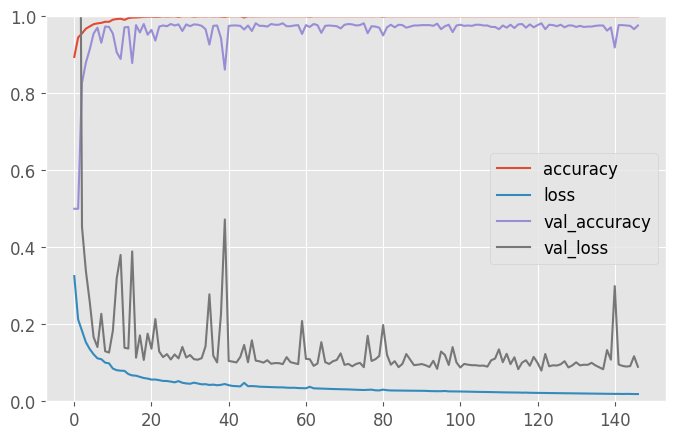

20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Accuracy:  0.9038
Precision: 0.8733
Recall:    0.9897
F1 Score:  0.9279
AUC:       0.9851
Metriche di performance ottenute: {'accuracy': 0.9038461538461539, 'precision': 0.8733031674208145, 'recall': 0.9897435897435898, 'f1': 0.9278846153846154, 'auc': 0.9851413543721236}


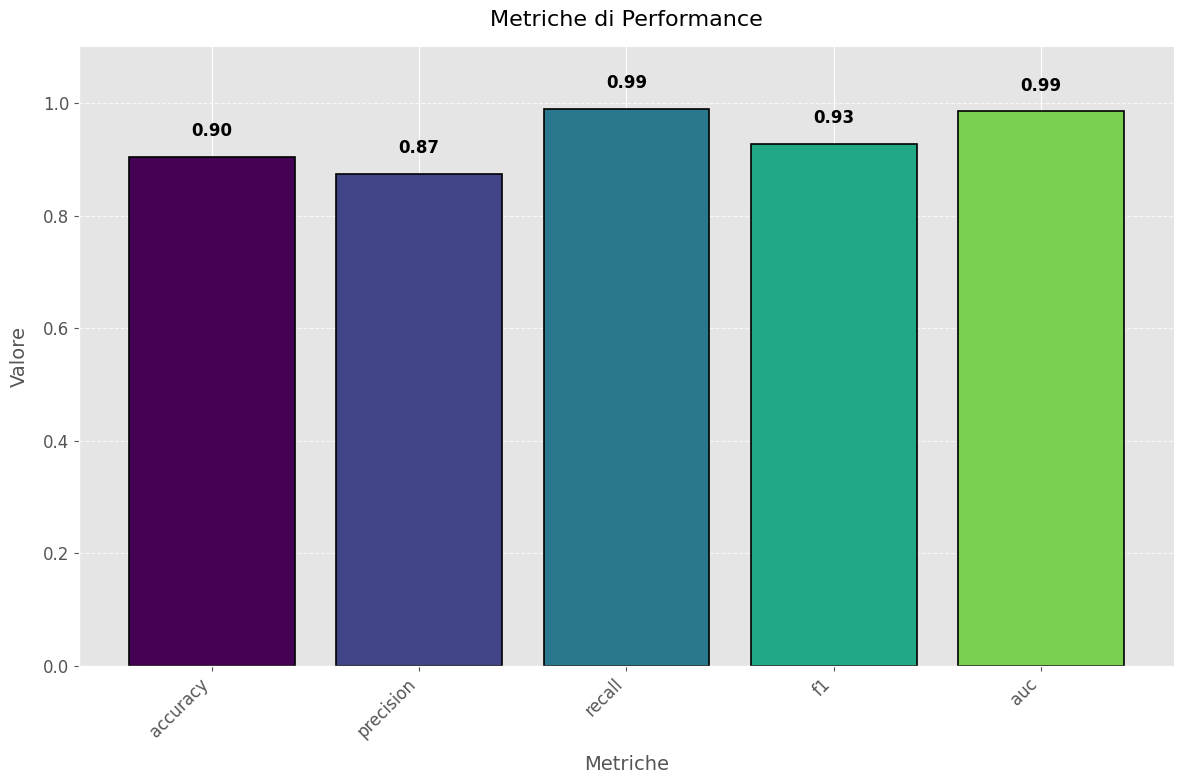

In [ ]:
import shutil
import tensorflow as tf
import gc
import os
import numpy as np
import random
import kerastuner as kt
from tensorflow import keras

##############################################################################
# Pulizia Sessione (opzionale)
##############################################################################
tf.keras.backend.clear_session()
tf.random.set_seed(50)
np.random.seed(50)
random.seed(50)

##############################################################################
# 1. Definiamo la funzione build_model per il Tuner
##############################################################################
def build_model(hp):
    model = keras.Sequential()

    # Iperparametri L2 per la regolarizzazione
    l2_reg_conv1 = hp.Float('l2_reg_conv1', min_value=1e-4, max_value=5e-3, sampling='log', default=1e-3)
    l2_reg_conv2 = hp.Float('l2_reg_conv2', min_value=1e-4, max_value=5e-3, sampling='log', default=1e-3)
    l2_reg_conv3 = hp.Float('l2_reg_conv3', min_value=1e-4, max_value=5e-3, sampling='log', default=1e-3)
    l2_reg_dense = hp.Float('l2_reg_dense', min_value=1e-4, max_value=5e-3, sampling='log', default=1e-3)

    # Iperparametro per il Dropout
    dropout_rate = hp.Float('dropout_rate', min_value=0.2, max_value=0.5, step=0.1, default=0.4)

    # Iperparametri per i filtri delle layer convoluzionali
    filters_1 = hp.Int('filters_1', min_value=16, max_value=32, step=4)
    filters_2 = hp.Int('filters_2', min_value=32, max_value=64, step=8)
    filters_3 = hp.Int('filters_3', min_value=64, max_value=128, step=16)

    # Primo layer conv
    model.add(keras.layers.Conv2D(
        filters=filters_1, kernel_size=(3, 3), activation='relu',
        input_shape=(64, 64, 1), padding='same',
        kernel_regularizer=keras.regularizers.l2(l2_reg_conv1)
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Secondo layer conv
    model.add(keras.layers.Conv2D(
        filters=filters_2, kernel_size=(3, 3), activation='relu',
        padding='same',
        kernel_regularizer=keras.regularizers.l2(l2_reg_conv2)
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2, 2)))

    # Terzo layer conv
    model.add(keras.layers.Conv2D(
        filters=filters_3, kernel_size=(3, 3), activation='relu',
        padding='same',
        kernel_regularizer=keras.regularizers.l2(l2_reg_conv3)
    ))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))

    # GlobalAveragePooling
    model.add(keras.layers.GlobalAveragePooling2D())

    # Layer Dense
    units_1 = hp.Int('units_1', min_value=64, max_value=128, step=16)
    model.add(keras.layers.Dense(
        units=units_1,
        activation='relu',
        kernel_regularizer=keras.regularizers.l2(l2_reg_dense)
    ))

    # Dropout
    model.add(keras.layers.Dropout(dropout_rate))

    # Output
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    # Definizione della schedule esponenziale per il learning rate
    initial_lr = hp.Float(
        'initial_lr',
        min_value=1e-6,  # alziamo la soglia minima
        max_value=2.1e-4,  # abbassiamo la soglia massima
        sampling='log',
        default=1e-4
    )
    decay_rate = 0.98
    # Riduciamo la frequenza di decadenza (1 riduzione ogni 2 epoche se hai 216 step/epoca)
    decay_steps = 216
    staircase = False

    lr_schedule = keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=initial_lr,
        decay_steps=decay_steps,
        decay_rate=decay_rate,
        staircase=staircase
    )
    optimizer = keras.optimizers.Adam(learning_rate=lr_schedule)

    # Compilazione
    model.compile(
        optimizer=optimizer,
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    return model

##############################################################################
# 2. Creazione del Tuner (BayesianOptimization)
##############################################################################
tuner = kt.BayesianOptimization(
    build_model,
    objective='val_accuracy',
    max_trials=5,  # Da aumentare a 10 o 15 per una ricerca più ampia
    executions_per_trial=1,
    directory='CNN_Tuning',
    project_name='Progetto_ML_Bayes',
    overwrite=True
)

##############################################################################
# 3. Callback per la ricerca
##############################################################################
early_stop_search = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

##############################################################################
# 4. Ricerca degli iperparametri (50 epoche)
##############################################################################
tuner.search(
    train_generator,
    validation_data=val_generator,
    epochs=50,
    callbacks=[early_stop_search]
)

##############################################################################
# 5. Recupera i migliori iperparametri
##############################################################################
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

best_hps_dict = {
    "filters_1":    best_hps.get('filters_1'),
    "filters_2":    best_hps.get('filters_2'),
    "filters_3":    best_hps.get('filters_3'),
    "units_1":      best_hps.get('units_1'),
    "dropout_rate": best_hps.get('dropout_rate'),
    "l2_reg_conv1": best_hps.get('l2_reg_conv1'),
    "l2_reg_conv2": best_hps.get('l2_reg_conv2'),
    "l2_reg_conv3": best_hps.get('l2_reg_conv3'),
    "l2_reg_dense": best_hps.get('l2_reg_dense'),
    "initial_lr":   best_hps.get('initial_lr')
}
print_best_params_table("Tuned CNN", best_hps_dict)

##############################################################################
# 6. Ricostruisci il modello migliore
##############################################################################
best_model = tuner.hypermodel.build(best_hps)

##############################################################################
# 7. Allenamento finale (max 100 epoche) con EarlyStopping
##############################################################################
final_callback = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=25,          # fermiamo se in 10 epoche consecutive la val_loss non migliora
    restore_best_weights=True
)

history = best_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=200,  # ridotto da 200
    callbacks=[final_callback]
)

##############################################################################
# 8. Valutazione sul test set
##############################################################################
test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))
print_message(f"Test Loss: {test_loss:.4f}", style="bold bright_red")
print_message(f"Test Accuracy: {test_accuracy:.4f}", style="bold bright_green")

##############################################################################
# 9. Preparazione dei dati di test (se serve per metriche aggiuntive)
##############################################################################
test_images, test_labels = [], []
for i in range(len(test_generator)):
    imgs, labs = next(test_generator)
    test_images.append(imgs)
    test_labels.append(labs)

test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

evaluate_cnn("Tuned CNN", best_model, test_images, test_labels, history)
metrics = evaluate_model_performance(best_model, test_images, test_labels)
print("Metriche di performance ottenute:", metrics)
plot_metrics(metrics, "Metriche di Performance")


# Salvataggio del modello allenato, ora va inserita la preferenza

In [1]:
# Per il formato H5:
model_save_path = "modello_tuned1.h5"
best_model.save(model_save_path)
print(f"Modello salvato con successo in '{model_save_path}'.")


NameError: name 'best_model' is not defined

# Rivalutazione Modello e caratteristiche

Questo script carica il modello e lo valuta sul test set.  

Una funzione consente di calcolare metriche di valutazione (accuratezza, precisione, recall e F1-score) variando la soglia di classificazione. Infine, un’interfaccia interattiva con uno slider permette di modificare la soglia decisionale, aggiornando dinamicamente le metriche e visualizzando un grafico della distribuzione delle probabilità predette, per facilitare l’analisi dell’impatto della soglia sulle prestazioni del modello.

In [9]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import clear_output
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

test_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/test'

test_datagen = ImageDataGenerator(rescale=1.0 / 255)
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(64,64),
    color_mode='grayscale',
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

# 1. Carica il modello salvato in formato H5
model_save_path = "/content/drive/My Drive/Colab Notebooks/chest_xray/best_model_so_far/best_model.h5"
model = keras.models.load_model(model_save_path)
print(f"Modello caricato correttamente da '{model_save_path}'.")

# 2. Valuta il modello sul test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# 3. Preparazione dei dati di test: concatenazione di tutti i batch provenienti dal test_generator
test_images, test_labels = [], []
for i in range(len(test_generator)):
    imgs, labs = next(test_generator)
    test_images.append(imgs)
    test_labels.append(labs)
test_images = np.concatenate(test_images, axis=0)
test_labels = np.concatenate(test_labels, axis=0)

# 4. Calcola le probabilità predette dal modello sul test set
y_pred_prob = model.predict(test_images).flatten()  # da (n_samples, 1) a vettore 1D
y_true = np.array(test_labels).flatten()

# 5. Definizione della funzione per il calcolo delle metriche in base a una soglia 'tau'
def compute_metrics(tau):
    # Converte le probabilità in predizioni binarie in base alla soglia
    y_pred_bin = (y_pred_prob > tau).astype(int)

    # Calcola la matrice di confusione (assumendo che entrambe le classi siano presenti)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred_bin).ravel()

    # Calcola le metriche
    accuracy = accuracy_score(y_true, y_pred_bin)
    precision = precision_score(y_true, y_pred_bin, zero_division=0)
    recall = recall_score(y_true, y_pred_bin, zero_division=0)
    f1 = f1_score(y_true, y_pred_bin, zero_division=0)

    return {
        'TP': tp,
        'FP': fp,
        'TN': tn,
        'FN': fn,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
    }

# 6. Funzione di aggiornamento interattivo: aggiorna le metriche e il grafico in base alla soglia scelta
def update_metrics(tau):
    metrics = compute_metrics(tau)
    clear_output(wait=True)  # Pulisce l'output per evitare ripetizioni nelle celle del notebook
    print(f"Soglia: {tau:.2f}\n")
    print(f"True Positives (TP): {metrics['TP']}")
    print(f"False Positives (FP): {metrics['FP']}")
    print(f"True Negatives (TN): {metrics['TN']}")
    print(f"False Negatives (FN): {metrics['FN']}\n")
    print(f"Accuracy:  {metrics['Accuracy']:.4f}")
    print(f"Precision: {metrics['Precision']:.4f}")
    print(f"Recall:    {metrics['Recall']:.4f}")
    print(f"F1-score:  {metrics['F1-score']:.4f}\n")

    # Visualizza il grafico della distribuzione delle probabilità predette
    plt.figure(figsize=(6,4))
    # Istogramma per le immagini della classe positiva
    plt.hist(y_pred_prob[y_true==1], bins=30, alpha=0.5, label="Classe 1 - PNEUMONIA")
    # Istogramma per le immagini della classe negativa
    plt.hist(y_pred_prob[y_true==0], bins=30, alpha=0.5, label="Classe 0 - NORMAL")
    plt.axvline(tau, color='k', linestyle='--', label=f"Soglia = {tau:.2f}")
    plt.xlabel("Probabilità predetta")
    plt.ylabel("Frequenza")
    plt.title("Distribuzione delle probabilità predette")
    plt.legend()
    plt.show()

# 7. Creazione dello slider interattivo per variare la soglia 'tau'
tau_slider = widgets.FloatSlider(
    value=0.5,
    min=0.3,
    max=0.7,
    step=0.01,
    description='Soglia:',
    continuous_update=False  # Aggiornamento al rilascio del mouse
)

# Collega lo slider alla funzione di aggiornamento
widgets.interact(update_metrics, tau=tau_slider);



Found 624 images belonging to 2 classes.


Modello caricato correttamente da '/content/drive/My Drive/Colab Notebooks/chest_xray/best_model_so_far/best_model.h5'.
20/20 ━━━━━━━━━━━━━━━━━━━━ 10s 361ms/step - accuracy: 0.7611 - loss: 0.8387
Test Loss: 0.5106
Test Accuracy: 0.8686
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 132ms/step


interactive(children=(FloatSlider(value=0.5, continuous_update=False, description='Soglia:', max=0.7, min=0.3,…

# VAE

Questo codice implementa un Variational Autoencoder per fare data augmentation sul nostro dataset. Il modello è composto da un encoder che riduce le immagini in un vettore latente probabilistico, un sampling layer che introduce variazioni stocastiche, e un decoder che ricostruisce immagini sintetiche a partire dal vettore latente. La funzione di perdita combina l'errore di ricostruzione (basato su MSE e SSIM) con la divergenza KL per regolarizzare lo spazio latente. Il modello viene addestrato iterativamente con un training loop personalizzato e early stopping per evitare overfitting. Alla fine del processo, il decoder viene utilizzato per generare nuove immagini sintetiche campionando dallo spazio latente.

In [ ]:
import tensorflow as tf
import numpy as np
import os
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import save_img

# Cartelle per il training e il test
train_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/train_ae_normal'
test_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/test'

# =========================================================
#                 GENERATORE IMMAGINI 64x64
# =========================================================
train_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(64, 64),
    batch_size=32,
    class_mode='binary',    # anche se per il VAE non conta molto la class_mode
    color_mode='grayscale'
)

# =========================================================
#                     COSTRUZIONE VAE
# =========================================================

# 1) ENCODER
def build_encoder(latent_dim):
    """ Crea un encoder che accetta immagini 64x64 (1 canale)
        e produce z_mean, z_log_var di dimensione (latent_dim,). """
    input_img = layers.Input(shape=(64, 64, 1))

    # Downsampling 1: da (64,64,1) -> (32,32,32)
    x = layers.Conv2D(32, kernel_size=3, strides=2, padding='same', activation='relu')(input_img)
    # Downsampling 2: da (32,32,32) -> (16,16,64)
    x = layers.Conv2D(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Flatten
    x = layers.Flatten()(x)  # dimensione 16*16*64 = 16384, abbiamo solo due layer

    # Densi finali per la distribuzione latente
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)

    return models.Model(input_img, [z_mean, z_log_var], name="encoder")

# 2) DECODER
def build_decoder(latent_dim):
    """ Crea un decoder che da (latent_dim,) risale a immagine 64x64 (1 canale). """
    latent_inputs = layers.Input(shape=(latent_dim,))

    # Ricostruisci la dimensione intermedia (16,16,64)
    x = layers.Dense(16 * 16 * 64, activation='relu')(latent_inputs)
    x = layers.Reshape((16, 16, 64))(x)

    # Upsampling 1: (16,16,64) -> (32,32,64)
    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same', activation='relu')(x)
    # Upsampling 2: (32,32,64) -> (64,64,32)
    x = layers.Conv2DTranspose(32, kernel_size=3, strides=2, padding='same', activation='relu')(x)

    # Ultimo layer: (64,64,32) -> (64,64,1)
    output_img = layers.Conv2DTranspose(
        1, kernel_size=3, padding='same', activation='sigmoid'
    )(x)

    return models.Model(latent_inputs, output_img, name="decoder")


# 3) SAMPLING LAYER
def sampling(args):
    """ Esegue z = z_mean + exp(0.5*z_log_var)*epsilon """
    z_mean, z_log_var = args
    batch = tf.shape(z_mean)[0]
    dim = tf.shape(z_mean)[1]
    epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
    return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Istanziamo encoder e decoder
latent_dim = 64
encoder = build_encoder(latent_dim)
decoder = build_decoder(latent_dim)

# Colleghiamo encoder -> sampling -> decoder
z_mean, z_log_var = encoder.output
z = layers.Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])
vae_output = decoder(z)

# Modello VAE completo
vae = models.Model(encoder.input, vae_output, name="vae")

# =========================================================
#               DEFINIZIONE LOSS (MSE + KL + SSIM)
# =========================================================

def reconstruction_loss_mse_ssim(y_true, y_pred, alpha=0.5):
    """
    Esempio di combinazione MSE con SSIM:
    - MSE standard
    - SSIM: vogliamo massimizzare SSIM, quindi minizziamo (1 - SSIM).
    - alpha è il peso per (1 - SSIM).
    """
    # MSE su batch
    mse = tf.reduce_mean(
        tf.reduce_sum(tf.square(y_true - y_pred), axis=(1, 2, 3))
    )
    # SSIM su batch (max_val=1.0 perché y_true,y_pred sono in [0,1])
    ssim_val = tf.image.ssim(y_true, y_pred, max_val=1.0)
    # calcoliamo media su batch
    ssim_loss = 1.0 - tf.reduce_mean(ssim_val)

    return mse + alpha * ssim_loss

def vae_loss(y_true, y_pred, z_mean, z_log_var, alpha=0.5):
    """
    Loss complessiva:
      = [MSE + alpha*(1 - SSIM)] + KL
    """
    # Ricostruzione
    reconstruction = reconstruction_loss_mse_ssim(y_true, y_pred, alpha=alpha)

    # KL
    kl = -0.5 * tf.reduce_mean(
        tf.reduce_sum(
            1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var),
            axis=1
        )
    )

    return reconstruction + kl

# =========================================================
#               TRAINING LOOP PERSONALIZZATO
# =========================================================

optimizer = tf.keras.optimizers.Adam()

@tf.function
def train_step(x_batch, alpha=0.5):
    with tf.GradientTape() as tape:
        z_mean_batch, z_log_var_batch = encoder(x_batch)
        z_batch = sampling([z_mean_batch, z_log_var_batch])
        y_pred_batch = decoder(z_batch)

        loss_batch = vae_loss(x_batch, y_pred_batch, z_mean_batch, z_log_var_batch, alpha)

    grads = tape.gradient(loss_batch, vae.trainable_variables)
    optimizer.apply_gradients(zip(grads, vae.trainable_variables))
    return loss_batch

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=15,
    restore_best_weights=True
)

epochs = 150
steps = train_generator.samples // train_generator.batch_size

for epoch in range(epochs):
    print(f"\nEpoch {epoch+1}/{epochs}")
    epoch_loss = 0.0

    # Training loop
    for step_i in range(steps):
        x_batch, _ = next(train_generator)
        # x_batch shape = (32, 64, 64, 1)
        batch_loss = train_step(x_batch, alpha=0.5)  # regola alpha a piacere
        epoch_loss += batch_loss

    epoch_loss /= steps
    print(f"  -> Training Loss: {epoch_loss:.4f}")

    # Esempio di validazione ogni 2 epoche (usa lo stesso generator come placeholder)
    if epoch % 2 == 0:
        val_loss = 0.0
        val_steps = max(1, steps // 10)
        for _ in range(val_steps):
            x_val_batch, _ = next(train_generator)
            z_mean_val, z_log_var_val = encoder(x_val_batch)
            z_val = sampling([z_mean_val, z_log_var_val])
            y_val_pred = decoder(z_val)
            val_loss += vae_loss(x_val_batch, y_val_pred, z_mean_val, z_log_var_val, alpha=0.5)

        val_loss /= val_steps
        print(f"  -> Validation Loss: {val_loss:.4f}")

    # Controllo manuale early stopping
    if early_stopping.stopped_epoch > 0:
        print(f"Early stopping at epoch {epoch+1}")
        break

# =========================================================
#            GENERAZIONE NUOVE IMMAGINI (64x64)
# =========================================================
latent_samples = np.random.normal(size=(2200, latent_dim))
generated_images = decoder.predict(latent_samples)

# Salvataggio su disco
generated_folder = '/content/drive/My Drive/Colab Notebooks/chest_xray/config2/NORMAL_AUGMENTED/'
os.makedirs(generated_folder, exist_ok=True)

for i, img in enumerate(generated_images):
    img_path = os.path.join(generated_folder, f"generated_{i}.png")
    save_img(img_path, img)

print(f"\nImmagini generate salvate in: {generated_folder}")


Found 1349 images belonging to 1 classes.

Epoch 1/150
  -> Training Loss: 177.2392
  -> Validation Loss: 92.5811

Epoch 2/150
  -> Training Loss: 87.1101

Epoch 3/150
  -> Training Loss: 72.8313
  -> Validation Loss: 68.4660

Epoch 4/150
  -> Training Loss: 66.4258

Epoch 5/150
  -> Training Loss: 63.9604
  -> Validation Loss: 58.6927

Epoch 6/150
  -> Training Loss: 62.1550

Epoch 7/150
  -> Training Loss: 60.0796
  -> Validation Loss: 60.1933

Epoch 8/150
  -> Training Loss: 58.3235

Epoch 9/150
  -> Training Loss: 57.2329
  -> Validation Loss: 58.8417

Epoch 10/150
  -> Training Loss: 56.9642

Epoch 11/150
  -> Training Loss: 55.9615
  -> Validation Loss: 57.5439

Epoch 12/150
  -> Training Loss: 54.6947

Epoch 13/150
  -> Training Loss: 54.4992
  -> Validation Loss: 54.8801

Epoch 14/150
  -> Training Loss: 52.9963

Epoch 15/150
  -> Training Loss: 52.4695
  -> Validation Loss: 52.5836

Epoch 16/150
  -> Training Loss: 52.4668

Epoch 17/150
  -> Training Loss: 52.2921
  -> Validat